# Задание 3 (анализ данных)

## Описание проекта

Необходимо провести анализ рекламного размещения клиента:
- оценить текущее положение клиента относительно конкурентов в категории (сравнительный анализ эффективности затрат);
- на основе выводов из п1 сформировать рекомендации по использованию инструментов, площадок, устройств.

Исходные данные:
- клиент: 'Омега';
- категории: Потребительское кредитование;
- период для анализа: янв – авг 2020;
- цель клиента: получать больше целевых визитов по меньшей стоимости.

## <a name="0"> Содержание: </a>
- [Загрузка данных и ознакомление с ними](#1)
- [Предобработка данных](#2)
- [Анализ данных](#3)
  - [Сравнение с конкурентами](#3.1)
  - [Рекомендации](#3.2)
- [Выводы](#4)

## <a name="1"> Загрузка данных и ознакомление с ними </a>

Загрузим библиотеки для работы с табличными данными и визуализации:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

Загрузим данные и выведем пять случайных строк:

In [2]:
df = pd.read_excel('/Users/polzovatel/Desktop/data.xls')
df.sample(5)

,Client,client_id,Month,Category,Device,Place,BannerType,QueryType (search only),TargetingType,Shows,Clicks,Cost_rub_wo_NDS,Сonversions
4398,Гамма,458303,2020-08-01,ДЕБЕТОВЫЕ КАРТЫ,Mobile,Search,text,Other,Phrase,23797,1686,1.741349e+05,120
8374,Сигма,357953,2020-02-01,ПОТРЕБИТЕЛЬСКОЕ КРЕДИТОВАНИЕ,Desktop,Search,text,Competitor,Phrase,98698,4396,1.868235e+05,340
8976,Омега,333348,2019-08-01,ПОТРЕБИТЕЛЬСКОЕ КРЕДИТОВАНИЕ,Mobile,Search,text,Other,Phrase,192017,23233,2.121561e+06,3439
9859,Гамма,458303,2020-03-01,РАСЧЕТНО-КАССОВОЕ ОБСЛУЖИВАНИЕ,Mobile,Networks,text,none,Retargeting,0,0,0.000000e+00,0
1653,Микрон,449955,2019-11-01,СТРАХОВАНИЕ ВЫЕЗЖАЮЩИХ ЗА РУБЕЖ,Mobile,Networks,image_ad,none,Phrase,30839,228,4.317739e+03,0


Посмотрим на объём таблицы, типы данных и наличие пропусков:

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11912 entries, 0 to 11911
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Client                   11912 non-null  object        
 1   client_id                11912 non-null  int64         
 2   Month                    11912 non-null  datetime64[ns]
 3   Category                 11912 non-null  object        
 4   Device                   11912 non-null  object        
 5   Place                    11912 non-null  object        
 6   BannerType               11912 non-null  object        
 7   QueryType (search only)  11912 non-null  object        
 8   TargetingType            11912 non-null  object        
 9   Shows                    11912 non-null  int64         
 10  Clicks                   11912 non-null  int64         
 11  Cost_rub_wo_NDS          11912 non-null  float64       
 12  Сonversions              11912 n

В таблице 11 911 строк, 13 столбцов, пропусков нет. Для каждого столбца добавим его описание:

- Client – название клиента
- client_id – идентификатор клиента
- Device – тип устройства
- Place – тип площадки
- BannerType – тип объявления
- QueryType – тип запроса (только для Place: Search)
- TargetingType – тип таргетинга
- Shows – Показы
- Clicks – Клики
- Cost_rub_wo_NDS – Расходы
- Conversions – Целевые визиты

Для удобства названия столбцов лучше привести к snake_case. С типами столбцов всё хорошо, менять не нужно. Также нужно проверить таблицу на наличие дублей. Сделаем это на этапе предобработки данных.

## <a name="2"> Предобработка данных </a>

Приведём названия столбцов к стилю snake_case:

In [4]:
df.columns = [i.lower() for i in df.columns]
df = df.rename(columns={'querytype (search only)': 'querytype_search_only'})
df.columns

Index(['client', 'client_id', 'month', 'category', 'device', 'place',
       'bannertype', 'querytype_search_only', 'targetingtype', 'shows',
       'clicks', 'cost_rub_wo_nds', 'сonversions'],
      dtype='object')

Теперь проверим таблицу на наличие дублей:

In [5]:
df.duplicated().sum()

0

Полных строк-дублей нет.

В исходных данных сказано, что для анализа необходимо взять период с января по август 2020 года. Поэтому очистим таблицу от несоответствующей информации:

In [6]:
df_filtered = df.query('"2020-01-01" <= month <= "2020-08-31"')
len(df_filtered)

5297

Также в исходных данных сказано, что рассматриваемая категория - потребительское кредитование. Исключим данные, не относящиеся к этой категории:

In [7]:
df_filtered_2 = df_filtered.query('category == "ПОТРЕБИТЕЛЬСКОЕ КРЕДИТОВАНИЕ"')
len(df_filtered_2)

1161

Было 11 911 строк, стало - 1161. Исключенные строки были нерелевантными.

Теперь данные предобработаны, можно переходить к их анализу.

## <a name="3"> Анализ данных </a>

### <a name="3.1"> Сравнение с конкурентами </a>

В рамках задания необходимо оценить текущее положение клиента, компании 'Омега', относительно конкурентов в категории (сравнительный анализ эффективности затрат). Сравнивать будем три метрики:
- CAC (стоимость привлечения клиента, отношение расходов к количеству целевых визитов) - так мы поймём, сколько платит 'Омега' и конкуренты за целевой визит;
- CPC (стоимость за клик, отношение расходов к количеству кликов) - так мы поймём, сколько платит 'Омега' и конкуренты за клик по баннеру и переход;
- CTR (конверсия показов в клики) - так мы оценим качество рекламного баннера и таргетинга. Это не финансовый показатель, но косвенно влияет на экономическую эффективность рекламы, если её стоимость зависит от количества показов.

Наиболее важный показатель - это CAC. Именно он и ARPPU - наиболее важные показатели, когда говорят и том, что юнит-экономика бизнеса должна сходиться. Тем не менее рассчитаем все три метрики для 'Омеги' и конкурентов.

Напишем функция, которая будет считать метрики в зависимости от параметра, по которому группируем данные:

In [8]:
def groupby(data, column):
    df_grouped = data.groupby(column).agg({'cost_rub_wo_nds': 'sum', 'сonversions': 'sum'
                                                  , 'shows': 'sum', 'clicks': 'sum'})
    df_grouped['cac'] = round(df_grouped['cost_rub_wo_nds'] / df_grouped['сonversions'])
    df_grouped['cpc'] = round(df_grouped['cost_rub_wo_nds'] / df_grouped['clicks'])
    df_grouped['ctr_%'] = round(df_grouped['clicks'] * 100 / df_grouped['shows'], 2)
    return df_grouped[['cac', 'cpc', 'ctr_%']]

Воспользуемся функцией и сгруппируем данные по компаниям:

In [9]:
clients_grouped = groupby(df_filtered_2, 'client')
clients_grouped.T

client,Альфа,Бета,Гамма,Зета,Лямбда,Мета,Омега,Псилон,Сигма
cac,622.00,651.00,260.00,1732.0,268.00,155.00,424.00,684.00,259.0
cpc,60.00,34.00,35.00,28.0,26.00,16.00,46.00,58.00,17.0
ctr_%,1.61,0.43,0.63,23.9,0.87,1.36,15.19,1.02,1.3


Сравним 'Омегу' и конкурентов, построим диаграмму по каждой метрике. Начнём с CAC:

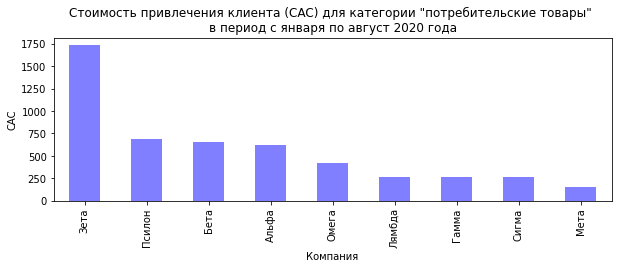

In [10]:
clients_grouped[['cac']].sort_values('cac', ascending=False).plot(kind='bar', alpha=.5, color='blue'
                                                             , figsize=(10, 3), legend=False)
plt.title('Стоимость целевого визита (CAC) для категории "потребительские товары" \nв период с января по август 2020 года') 
plt.xlabel("Компания")
plt.ylabel("CAC, ден. ед.") 
plt.show()

Выделяется 'Зета' - эта компания тратит значительно больше других конкурентов за целевой визит - 1732 ден. ед. 'Омега ' в середине списка - она тратит 424 ден. ед. Меньше всего у 'Мета' - 155 ден. ед.

Построим диаграмму по CPC:

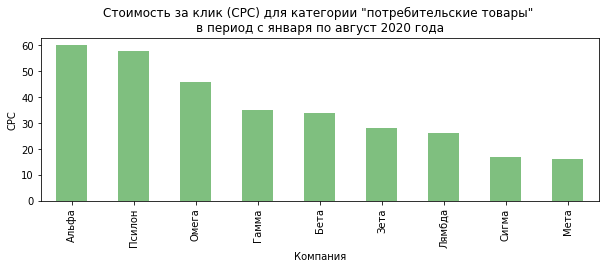

In [11]:
clients_grouped[['cpc']].sort_values('cpc', ascending=False).plot(kind='bar', alpha=.5, color='green'
                                                             , figsize=(10, 3), legend=False)
plt.title('Стоимость за клик (CPC) для категории "потребительские товары" \nв период с января по август 2020 года') 
plt.xlabel("Компания")
plt.ylabel("CPC, ден. ед.") 
plt.show()

'Омега' со значением 46 ден. ед. находится в тройке компаний, которые тратят больше конкурентов за клик. Меньше всего опять у 'Мета' - 16 ден. ед. 'Омеге' есть куда стремиться.

Построим диаграмму по CTR:

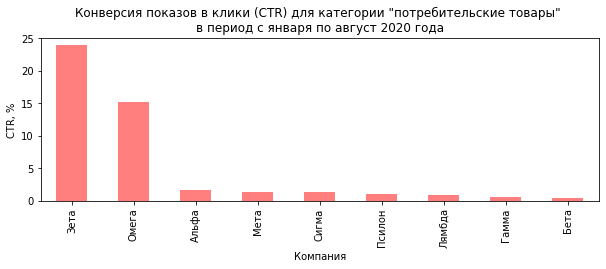

In [12]:
clients_grouped[['ctr_%']].sort_values('ctr_%', ascending=False).plot(kind='bar', alpha=.5, color='red'
                                                             , figsize=(10, 3), legend=False)
plt.title('Конверсия показов в клики (CTR) для категории "потребительские товары" \nв период с января по август 2020 года') 
plt.xlabel("Компания")
plt.ylabel("CTR, %") 
plt.show()

У 'Зеты' и 'Омеги' очень хорошие показатели CTR по сравнению с конкурентами - 24 и 15% соответственно. А вот 'Мета', лидер по самым дешёвым целевым визитам, имеет конверсию всего лишь 1,4%. Это означает, что эта компания закупает показы за очень низкую цену по сравнению с конкурентами.

В целом можно сказать, что по основной метрике, CAC, 'Омега' является середняком и показатель можно улучшать. Посмотрим, как это можно сделать.

### <a name="3.2"> Рекомендации </a>

Составим рекомендации для 'Омеги'. Изучим, как метрики зависят от различных признаков. Сначала оставим только данные по 'Омеге':

In [13]:
df_omega = df_filtered_2.query('client == "Омега"')
len(df_omega)

86

86 строк с данными по 'Омеге'. Посмотрим зависимость метрик от типа устойства:

In [14]:
omega_device_grouped = groupby(df_omega, 'device')
omega_device_grouped.T

device,Desktop,Mobile
cac,642.00,326.00
cpc,56.00,40.00
ctr_%,12.24,17.94


Целевой визит дешевле для мобильных устройств, там и конверсия в клики выше. Значит имеет смысл перераспределять бюджет в пользу этого типа устройств.

Посмотрим на зависимость от площадки:

In [15]:
omega_place_grouped = groupby(df_omega, 'place')
omega_place_grouped.T

place,Networks,Search
cac,0.0,424.00
cpc,NaN,46.00
ctr_%,NaN,15.19


'Омега' размещается только на площадке `Search`. Возможно имеет смысл попробовать площадку `Networks`. Ответим на этот вопрос чуть позже.

Посмотрим на зависимость от типа запроса:

In [16]:
omega_querytype_grouped = groupby(df_omega, 'querytype_search_only')
omega_querytype_grouped.T

querytype_search_only,Brand,Competitor,Other,none
cac,326.00,831.00,564.0,0.0
cpc,32.00,67.00,73.0,NaN
ctr_%,19.16,5.92,11.3,NaN


Самые дешёвые целевые визиты для запросов типа `Brand`, также CTR самый высокий. Имеет смысл перераспределять бюджет в пользу этого типа запросов.

Посмотрим на зависимость от типа баннера:

In [17]:
omega_bannertype_grouped = groupby(df_omega, 'bannertype')
omega_bannertype_grouped.T

bannertype,cpm_banner,image_ad,text
cac,NaN,NaN,424.00
cpc,NaN,NaN,46.00
ctr_%,NaN,NaN,15.19


Есть данные только для типа `text`. Возможно имеет смысл попробовать другие типы баннеров. Ответим на этот вопрос чуть позже.

Посмотрим на зависимость от типа таргетинга:

In [18]:
omega_targeting_grouped = groupby(df_omega, 'targetingtype')
omega_targeting_grouped.T

targetingtype,Autotargeting,Phrase,Retargeting
cac,NaN,424.00,0.0
cpc,NaN,46.00,NaN
ctr_%,NaN,15.19,NaN


Есть данные только для типа `Phrase`. Возможно имеет смысл попробовать другие типы таргетингов.

Чтобы оценить, насколько эффективны другие типы таргетингов, а также типы баннеров и площадок, посмотрим на конкурентов. Составим таблицу с данными только для конкурентов:

In [19]:
df_other = df_filtered_2.query('client != "Омега"')
len(df_other)

1075

1075 строк. Посмотрим на зависимость от площадки:

In [20]:
other_place_grouped = groupby(df_other, 'place')
other_place_grouped.T

place,Networks,Search
cac,542.00,368.00
cpc,13.00,39.00
ctr_%,0.34,16.35


Площадка `Search` показывает себя в среднем лучше. 'Омега' правильно её выбрала.

Посмотрим на зависимость от типа баннера:

In [21]:
other_bannertype_grouped = groupby(df_other, 'bannertype')
other_bannertype_grouped.T

bannertype,cpc_video,cpm_banner,image_ad,mcbanner,performance,text
cac,33874.0,1140.00,1277.00,726.00,NaN,389.00
cpc,9.0,10.00,9.00,154.00,NaN,29.00
ctr_%,0.5,0.18,0.43,0.92,NaN,0.84


Тип баннера `text` показывает себя в среднем лучше. 'Омега' правильно его выбрала.

Посмотрим на зависимость от типа таргетинга:

In [22]:
other_targeting_grouped = groupby(df_other, 'targetingtype')
other_targeting_grouped.T

targetingtype,Autotargeting,Phrase,Retargeting
cac,282.00,391.00,469.00
cpc,25.00,29.00,15.00
ctr_%,4.96,0.84,0.41


Тип таргетинга `Autotargeting` показывает себя в среднем лучше. А 'Омега' использует только `Phrase`. Имеет смысл попробовать `Autotargeting`.

## <a name="4"> Выводы </a>

По итогам исследования мы выяснили, что: 
- целевые визиты у 'Омеги' дешевле для устройств типа `Mobile`, нежели для `Desktop` - 326 ден. ед. за целевой визит против 642. Также они дешевле для запросов типа `Brand`, нежели для `Competitor` и `Other` - 326 против 831 и 564;
- 'Омега' правильно выбрала площадку `Search` и тип баннера `text` - они показывает себя в среднем лучше альтернатив;
- имеет смысл перейти с типа таргетинга `Phrase` на `Autotargeting`. В среднем последний показывает себя более эффективным у конкурентов - 282 против 391.